In [1]:
#!pip install medmnist

In [2]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import os
import torch

from medmnist import dataset
from medmnist import INFO

import matplotlib.pyplot as plt

In [3]:
# Define params for the NN training
n_epochs = 10
batch_size = 32
lr_g = 0.0002
lr_d = 0.0007
b1 = 0.5
b2 = 0.999
n_cpu = -1
latent_dim = 128
n_classes = 11
img_size = 28
channels = 1
sample_interval = 400

In [4]:
img_shape = (channels, img_size, img_size)
os.makedirs("images", exist_ok=True)
cuda = True if torch.cuda.is_available() else False

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            # layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Tanh())
            # layers.append(nn.ReLU())
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 256),
            *block(256, 512),
            # *block(512, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            # nn.Tanh()
            nn.Sigmoid()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            # layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.ReLU())
            return layers


        self.model = nn.Sequential(
            *block(n_classes + int(np.prod(img_shape)), 1024, normalize=False),
            # *block(1024, 1024),
            *block(1024, 512),
            *block(512, 512),
            *block(512, 512),
            *block(512, 512),
            *block(512, 512),
            *block(512, 256),
            *block(256, 128),
            nn.Linear(128, 1),
            nn.Sigmoid()
            )

        # self.model = nn.Sequential(
        #     nn.Linear(n_classes + int(np.prod(img_shape)), 512),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Linear(512, 512),
        #     nn.Dropout(0.4),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Linear(512, 512),
        #     nn.Dropout(0.4),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Linear(512, 512)
        #     )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [7]:
class Discriminator_CNN(nn.Module):
    def __init__(self, img_shape=img_shape):
        super(Discriminator_CNN, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)
        
        self.label_input = nn.Sequential(
            nn.Linear(n_classes, int(np.prod(img_shape))),
            nn.Tanh(), 
            nn.Unflatten(1, img_shape)
        )

        self.model = nn.Sequential(
            nn.Conv2d(2, 3, (3,3), stride=1, padding='valid'),
            nn.ReLU(),
            nn.Conv2d(3, 3, (3,3), stride=1, padding='valid'),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Conv2d(3, 3, (3,3), stride=1, padding='valid'),
            # nn.LazyBatchNorm2d(),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.LazyLinear(1),
            nn.Sigmoid()
            )     


    def forward(self, img, labels):
        process_label = self.label_input(self.label_embedding(labels))

        d_in = torch.cat((img, process_label), 1)

        validity = self.model(d_in)
        return validity

In [8]:
class Generator_CNN(nn.Module):
    def __init__(self, latent_dim=latent_dim):
        super(Generator_CNN, self).__init__()

        # def block(in_channels, out_channels, kernel_size, normalize=True):
        #     layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size)]
        #     if normalize:
        #         layers.append(nn.LazyBatchNorm2d)
        #     # layers.append(nn.LeakyReLU(0.2, inplace=True))
        #     layers.append(nn.Tanh())
        #     # layers.append(nn.ReLU())
        #     return layers

        self.label_emb = nn.Embedding(n_classes, n_classes)

        self.label_input = nn.Sequential(
            nn.Linear(n_classes, int(np.prod((12,12)))),
            nn.Tanh(), 
            nn.Unflatten(1, (-1, 12, 12))
        )

        self.noise_input = nn.Sequential(
            nn.Linear(latent_dim, int(np.prod((12,12)))),
            nn.Tanh(), 
            nn.Unflatten(1, (-1, 12, 12))
        )

        self.model = nn.Sequential(
            # nn.Linear()
            nn.LazyConvTranspose2d(3, (5,5), stride=2),
            nn.LazyBatchNorm2d(),
            nn.Tanh(),
            nn.ConvTranspose2d(3, 3, (3,3)),
            nn.LazyBatchNorm2d(),
            nn.Tanh(),
            nn.ConvTranspose2d(3, 3, (3,3), stride=1),
            nn.LazyBatchNorm2d(),
            nn.Tanh(),
            nn.ConvTranspose2d(3, 3, (3,3), stride=1),
            nn.LazyBatchNorm2d(),
            nn.Tanh(),
            nn.ConvTranspose2d(3, 2, (3,3), stride=1),
            nn.LazyBatchNorm2d(),
            nn.Tanh(),
            nn.ConvTranspose2d(2, 1, (3,3)),
            nn.LazyBatchNorm2d(),
            nn.Tanh(),
            # nn.ConvTranspose2d(2, 1, (1,1)),
            # nn.LazyBatchNorm2d(),
            nn.Flatten(),
            nn.LazyLinear(int(np.prod(img_shape))),
            nn.LazyBatchNorm1d(),
            nn.Tanh(),
            nn.LazyLinear(int(np.prod(img_shape))),
            nn.Tanh()
            # nn.Sigmoid()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        # gen_input_processed = self.label_input(gen_input)
        # cat_input = torch.cat((self.label_emb(labels), noise), -1)
        # gen_input = self.noise_input(cat_input)

        noise_processed = self.noise_input(noise)
        label_processed = self.label_input(self.label_emb(labels))
        gen_input = torch.cat((label_processed, noise_processed), 1)
    
        img = self.model(gen_input)
        # print(img.shape)
        img = img.view(img.size(0), *img_shape)
        return img

In [9]:
torch.manual_seed(1234)
np.random.seed(1234)
# Loss functions
adversarial_loss = torch.nn.BCELoss() #torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator_CNN()
discriminator = Discriminator_CNN()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
data_dir = "../../data/medmnist"  # Path to the MedMNIST dataset directory
os.makedirs(data_dir, exist_ok=True)

dataloader = torch.utils.data.DataLoader(
    dataset.OrganAMNIST(
        # root=data_dir,
        split='train',
        transform=transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ]),
        target_transform=transforms.Lambda(lambda x: x[0]),
        # flag=dataset_name,
        download=True
    ),
    batch_size=batch_size,
    shuffle=True
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, epoch, batch_num, safe=True):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    if safe:
        save_image(gen_imgs.data, "images/%d_%d.png" % (epoch, batch_num), nrow=n_row, normalize=True)
    else:
        return gen_imgs


# ----------
#  Training
# ----------

for epoch in range(n_epochs):
    avg_g_loss = 0
    avg_d_loss = 0
    avg_d_fakes = 0
    avg_d_real = 0

    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------


        # set modes
        generator.train()
        discriminator.eval()
        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity_fake = discriminator(gen_imgs, gen_labels)

        g_loss = adversarial_loss(validity_fake, valid)

        g_loss.backward()
        optimizer_G.step()

        # print(g_loss)
        avg_g_loss += g_loss.item()
        # break
        # ---------------------
        #  Train Discriminator
        # ---------------------


        # set modes
        discriminator.train()
        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)
        # avg_d_real += sum(validity_real)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)
        # avg_d_fakes += sum(validity_fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        # print(d_loss)
        d_loss.backward()
        # break
        optimizer_D.step()

        avg_d_loss += d_loss.item()
         
        # print(
        #     "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        #     % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        # )
        # batches_done = epoch * len(dataloader) + i
        if i % sample_interval == 0:
            sample_image(n_row=n_classes, epoch=epoch, batch_num=i)

    
    avg_g_loss /= len(dataloader)
    avg_d_loss /= len(dataloader)
    # avg_d_real /= len(dataloader)
    # avg_d_fakes /= len(dataloader)
    sample_image(n_row=n_classes, epoch=epoch, batch_num=i)
    print(
            "[Epoch %d/%d] [D loss: %f] [G loss: %f] [D real: %f] [D fake: %f]"
            % (epoch+1, n_epochs, avg_d_loss, avg_g_loss, avg_d_real, avg_d_fakes)
        )

/home/rh/Uni/DLAM/.venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Using downloaded and verified file: /home/rh/.medmnist/organamnist.npz
[Epoch 1/10] [D loss: 0.686545] [G loss: 0.715422] [D real: 0.000000] [D fake: 0.000000]
[Epoch 2/10] [D loss: 0.667659] [G loss: 0.779017] [D real: 0.000000] [D fake: 0.000000]
[Epoch 3/10] [D loss: 0.667810] [G loss: 0.778575] [D real: 0.000000] [D fake: 0.000000]
[Epoch 4/10] [D loss: 0.667938] [G loss: 0.777352] [D real: 0.000000] [D fake: 0.000000]
[Epoch 5/10] [D loss: 0.667501] [G loss: 0.778951] [D real: 0.000000] [D fake: 0.000000]
[Epoch 6/10] [D loss: 0.667155] [G loss: 0.780762] [D real: 0.000000] [D fake: 0.000000]
[Epoch 7/10] [D loss: 0.668141] [G loss: 0.776123] [D real: 0.000000] [D fake: 0.000000]
[Epoch 8/10] [D loss: 0.667138] [G loss: 0.780457] [D real: 0.000000] [D fake: 0.000000]
[Epoch 9/10] [D loss: 0.666767] [G loss: 0.780940] [D real: 0.000000] [D fake: 0.000000]
[Epoch 10/10] [D loss: 0.667345] [G loss: 0.779880] [D real: 0.000000] [D fake: 0.000000]


In [10]:
dataloader_test = torch.utils.data.DataLoader(
    dataset.OrganAMNIST(
        # root=data_dir,
        split='test',
        transform=transforms.Compose([
            # transforms.Resize(img_size),
            transforms.ToTensor(),
            # transforms.Normalize([0.5], [0.5])
        ]),
        target_transform=transforms.Lambda(lambda x: x[0]),
        # flag=dataset_name,
        download=True
    ),
    batch_size=batch_size,
    shuffle=True
)

Using downloaded and verified file: /home/rh/.medmnist/organamnist.npz


In [11]:
dataloader.dataset[0][0].shape

torch.Size([1, 28, 28])

In [12]:
# Create a random 1x32x32 tensor
# for i in range(5):
#   tensor = dataloader_test.dataset[i][0]
#   label = dataloader_test.dataset[i][1]

#   # Convert the tensor to a numpy array
#   array = tensor.numpy()

#   # Reshape the array to 32x32
#   reshaped_array = array.reshape(28, 28)

#   # Plot the array as an image
#   print(label)
#   plt.imshow(reshaped_array, cmap='gray')
#   plt.show()

0.40241119265556335 0


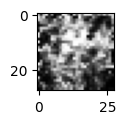

0.3533777892589569 1


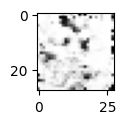

0.34498947858810425 2


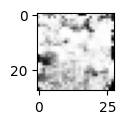

0.3566736578941345 3


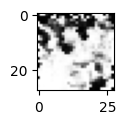

0.5449034571647644 4


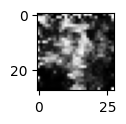

0.5372735261917114 5


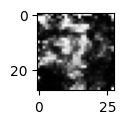

0.6283681392669678 6


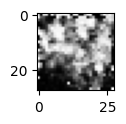

0.5465995669364929 7


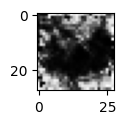

0.5404544472694397 8


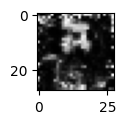

0.4916801452636719 9


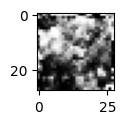

0.5147770643234253 10


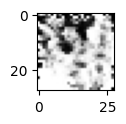

In [13]:
# generator = Generator()
# discriminator

generator.eval().cpu()
discriminator.eval().cpu()
for i in range(11):
  # tensor = dataloader.dataset[i][0]
  z = Variable(FloatTensor(np.random.normal(0, 1, (1, latent_dim)))).cpu()
  # gen_labels = Variable(LongTensor(np.ones(1)*6)).cpu()
  gen_labels = Variable(LongTensor(np.ones(1)*i)).cpu()
  # gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, 1))).cpu()

  # Generate a batch of images
  tensor = generator(z, gen_labels)
  # Loss measures generator's ability to fool the discriminator
  validity_fake = discriminator(tensor, gen_labels)

  print(validity_fake.item(), gen_labels.item())
  # Convert the tensor to a numpy array
  array = tensor.detach().numpy()

  # Reshape the array to 32x32
  reshaped_array = array.reshape(28, 28)

  # Plot the array as an image
  plt.figure(figsize=(1,1))
  plt.imshow(reshaped_array, cmap='gray')
  plt.show()

In [14]:
generator.eval().cpu()
discriminator.eval().cpu()

# number of images per class
n_images = 500

test_images = np.ones((n_images * n_classes, img_shape[1], img_shape[2]), dtype=float)
test_labels = np.ones((n_images * n_classes, 1))

for n in range(n_images):
  for i in range(n_classes):

    z = Variable(FloatTensor(np.random.normal(0, 1, (1, latent_dim)))).cpu()
    gen_labels = Variable(LongTensor(np.ones(1)*i)).cpu()

    # Generate a batch of images
    tensor = generator(z, gen_labels).squeeze()
    # Convert the tensor to a numpy array
    img = tensor.detach().numpy()

    test_images[n*n_classes+i] = img
    test_labels[n*n_classes+i] = gen_labels.item()

    # print(n*n_classes+i, type(img), gen_labels.item())



In [15]:
# np.savez("generated_organamnist.npz", test_images=test_images, test_labels=test_labels)

In [16]:
sum(dataloader_test.dataset.labels == [0])

array([1036])

In [17]:
for i in range(11):
    print(i, sum(dataloader.dataset.labels == [i]))

0 [1956]
1 [1408]
2 [1359]
3 [1474]
4 [3963]
5 [3817]
6 [6164]
7 [3919]
8 [3929]
9 [3031]
10 [3561]


In [18]:
tmp = np.load("/home/rh/.medmnist/organamnist.npz")

In [19]:
tmp["train_images"].shape

(34581, 28, 28)

In [20]:
tmp = np.load("tmp.npz")

In [21]:
tmp["test_images"].shape

(22, 28, 28)